In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


這次的範例主要參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter08/maze.py)

Chapter 8主要結合planning與learning，讓過往的經驗可以再次得到一次利用

Example 8.4: Prioritized Sweeping on Mazes

Prioritized sweeping可以明顯地提高在迷宮任務中找尋最佳路徑的速度，通常是5到10倍。一個常見的範例如下圖：
![](https://i.imgur.com/zP3Fo7y.png)


這些資料跟Figure 8.2看到的是完全相同的結構，就只有[網格的解析度](http://terms.naer.edu.tw/detail/389282/)不同。Prioritized sweeping比起非優先序的Dyna-Q有著明顯優勢。兩個系統在每次與環境互動中，最多就是做了$n=5$的更新。故事範例改編自Peng and Williams (1993)。

Example 8.4採用與Example 8.1一樣的迷宮來與Dyna-Q做比較，特別的是，它做了縮放，所以我們要在Maze中加入新的縮放功能。

下面給出原始迷宮，比較有感覺：  

  
![](https://i.imgur.com/pwVihdo.png)

首先載入需求套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from copy import deepcopy

首先設置Environment

In [3]:
class Maze:
    def __init__(self):
        """初始化環境
        
        根據範例說明：
        1. 這是一個寬9高6的gridworld
        2. 每個episode的start state都是[2, 0]
        3. goal state為[8, 0]
        4. 我們能做的action就是上下左右
        5. 路面上是有障礙
        """
        self.WORLD_WIDTH = 9
        self.WORLD_HEIGHT = 6
        
        self.START_STATE = [2, 0]
        self.GOAL_STATE = [[0, 8]]
        
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.action_space = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]
        # 障礙設置
        self.obstacles = [[1, 2], [2, 2], [3, 2], 
                          [4, 5], 
                          [0, 7], [1, 7], [2, 7]]
        
        self.value_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.action_space))
        
        self.max_steps = float('inf')
        
        self.resolution = 1
    def step(self, state, action):
        """run step according action
        
        state: 當前的狀態
        action: 要執行的action
        
        幾點要注意：
            1. 不能超出邊界，這可以用max、min來處理
            2. 撞到障礙就是停在原地
            3. 每次的reward都是0，除非你到達goal state
            
        return next_state, reward
        """
        x, y = state
        
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif  action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif  action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif  action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        
        if [x, y] in self.obstacles:
            x, y = state
        
        if [x, y] in self.GOAL_STATE:
            reward = 1.0
        else:
            reward = 0.0
        
        return [x, y], reward
    
    def extend_state(self, state, factor):
        """迷宮怎麼放大，相關狀態就怎麼跟著放大"""
        new_state = [state[0] * factor, state[1] * factor]
        new_states = []
        
        for i in range(0, factor):
            for j in range(0, factor):
                new_states.append([new_state[0] + i, new_state[1] + j])
        return new_states
        
    def extend_maze(self, factor):
        """放大迷宮
        
        factor: 放大倍率
        
        放大之後連面積都跟著變大，除了起始狀態之外。
        """
        new_maze = Maze()
        new_maze.WORLD_WIDTH = self.WORLD_WIDTH * factor
        new_maze.WORLD_HEIGHT = self.WORLD_HEIGHT * factor
        new_maze.START_STATE = [self.START_STATE[0] * factor, self.START_STATE[1] * factor]
        new_maze.GOAL_STATE = self.extend_state(self.GOAL_STATE[0], factor)
        
        new_maze.obstacles = []
        for state in self.obstacles:
            new_maze.obstacles.extend(self.extend_state(state, factor))
        
        new_maze.value_size = (new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.action_space))
        
        # 這後續有用，要記錄著
        new_maze.resolution  = factor
        
        return new_maze

In [4]:
maze = Maze()
assert maze.START_STATE == [2, 0]
assert maze.GOAL_STATE[0] == [0, 8]
assert (maze.step([2, 0], 0)) == ([1, 0], 0)

測試放大迷宮

In [5]:
new_maze = maze.extend_maze(2)
print('start state: ', new_maze.START_STATE)
print('goal state: ', new_maze.GOAL_STATE)
print('obstacles: ', new_maze.obstacles)

start state:  [4, 0]
goal state:  [[0, 16], [0, 17], [1, 16], [1, 17]]
obstacles:  [[2, 4], [2, 5], [3, 4], [3, 5], [4, 4], [4, 5], [5, 4], [5, 5], [6, 4], [6, 5], [7, 4], [7, 5], [8, 10], [8, 11], [9, 10], [9, 11], [0, 14], [0, 15], [1, 14], [1, 15], [2, 14], [2, 15], [3, 14], [3, 15], [4, 14], [4, 15], [5, 14], [5, 15]]


然後我們會需要一個model來記錄曾經有過的經驗

In [6]:
class TrivialModel:
    def __init__(self, rand=np.random):
        # 用dict來做模型，反正我們只會記錄該state-action pair最後一次的經驗
        self.model = dict()
        self.rand = rand
#         self.rand.seed(10)
    
    def feed(self, state, action, next_state, reward):
        """記錄經驗"""
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        # 判斷該組state是否存在目前的model
        # 如不存在就賦予一個預設值
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]
        
    def sample(self):
        """隨機取一筆經驗出來再做更新"""
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

另外再一個prioritiy model，在設置model之前我們要先定義一個priority queue

queue的部份，作者是採用python標準庫中的heapq，heap本身是個結構，在sorting上非常實用，可[參考在下記錄](https://martychen920.blogspot.com/2020/10/algorithmsortheap-srot.html)，heapq的話可以參考[官方文件說明](https://docs.python.org/zh-tw/3/library/heapq.html)，根據官方文件說明，heapq本身即為優先佇列 (priority queue)，正好符合我們的需求

In [7]:
import heapq

In [8]:
class PriorityQueue:
    def __init__(self):
        self.pq = [] # for heapq
        self.entry_finder = {}
        self.REMOVED = '<removed-task>'
        self.counter = 0
    
    def add_item(self, item, priority=0):
        """新增item
        
        如果存在記錄就先移除，然後再重新寫入一筆新的
        最後記得利用heapq做個sorting
        """
        if item in self.entry_finder:            
            self.remove_item(item)
            
        
        entry = [priority, self.counter, item]
        self.counter += 1
        self.entry_finder[item] = entry        
        heapq.heappush(self.pq, entry)
        
    def remove_item(self, item):
        """item移除之後"""        
        entry = self.entry_finder.pop(item)
        entry[-1] = self.REMOVED        
    
    def pop_item(self):
        while self.pq:
            priority, count, item = heapq.heappop(self.pq)
            if item is not self.REMOVED:
                del self.entry_finder[item]
                return item, priority
        
        raise KeyError('pop from an empty priority queue')
    
    def empty(self):
        return not self.entry_finder

In [9]:
abc = {}
abc = {'ccc': 123, 'ddd':234}

In [10]:
ggg = abc.pop('ccc')
ggg

123

In [11]:
abc

{'ddd': 234}

下面測試可以看的出來，最小的是最後寫入的，但仍然會在最上面

In [12]:
pq = PriorityQueue()
pq.add_item('test1', 9)
pq.add_item('test2', 5)
pq.add_item('test3', 0)
pq.pq

[[0, 2, 'test3'], [9, 0, 'test1'], [5, 1, 'test2']]

測試一下pop，確認一下是不是會pop出最小的那一個

In [13]:
assert pq.pop_item() == ('test3', 0)

In [14]:
pq.pq

[[5, 1, 'test2'], [9, 0, 'test1']]

In [15]:
pq.entry_finder

{'test1': [9, 0, 'test1'], 'test2': [5, 1, 'test2']}

In [16]:
pq.remove_item('test1')
pq.entry_finder

{'test2': [5, 1, 'test2']}

In [17]:
class PriorityModel:
    def __init__(self, rand=np.random):        
        self.model = dict()
        self.rand = rand
        self.priority_queue = PriorityQueue()
        self.predecessors = dict()
    
    def insert(self, priority, state, action):
        """將state-action pair寫入優先序佇列
        
        要注意的是，優先度我們是取負值，因為heapq是minimum heap，所以取負讓大的變小
        """
        self.priority_queue.add_item((tuple(state), action), -priority)
    
    def empty(self):
        """回傳目前的佇列是否為空"""
        return self.priority_queue.empty()
    
    def sample(self):
        """取得priority queue的root item
        
        要記得，寫入的時候優先度是取負，所以取回的時候也要記得取負
        """
        (state, action), priority = self.priority_queue.pop_item()
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return -priority, list(state), action, list(next_state), reward
    
    def feed(self, state, action, next_state, reward):
        """經驗寫入model"""
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        # 這邊寫入的是state action pair的next state
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
            
        self.model[tuple(state)][action] = [list(next_state), reward]
        
        # 這邊寫入的是進入next state之前的state action pair
        if tuple(next_state) not in self.predecessors.keys():
            self.predecessors[tuple(next_state)] = set()
            
        self.predecessors[tuple(next_state)].add((tuple(state), action))
    
    def predecessor(self, state):
        """取得進入目標state之前的state action pairs與reward"""
        if tuple(state) not in self.predecessors.keys():
            return []
        
        predecessors  = []
        for state_pre, action_pre in list(self.predecessors[tuple(state)]):
            predecessors.append([list(state_pre), action_pre, self.model[state_pre][action_pre][1]])
        
        return predecessors

然後我們來設置一下Dyna-Q所需要的參數：
* gamma: discount factor
* epsilon: 探索的機率
* planning_steps: planning steps
* average_runs: 幾次的run計算平均

In [18]:
dyna_q_params = {
    'gamma': 0.95,
    'epsilon': 0.1,
    'planning_steps': 5,
    'average_runs': 10,     
    'alpha': 0.5
}

In [19]:
priority_params = {
    'gamma': 0.95,
    'epsilon': 0.1,
    'planning_steps': 5,
    'average_runs': 10,     
    'alpha': 0.5,
    'theta': 0.0001
}

設置一個已經很熟悉的，用來選擇action的function

In [20]:
def action_selection(state, value_function, maze, dyna_params):
    """選擇action的function
    
    後來自己被很多q_value參數搞混，所以就試著分開來命名
    
    state: current state
    value_function: action value function, that is q_value
    maze: object for Maze
    dyna_params: algorithm's parameters
    """
    if np.random.binomial(1, dyna_q_params['epsilon']) == 1:
        return np.random.choice(maze.action_space)
    else:
        # 取得該state的所有可能的action
        values = value_function[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])
    

接著來設置Dyna-Q algorithm，下面給出完整演算法的pseudocode

![](https://i.imgur.com/jo168Rh.png)

In [21]:
def dyna_q_algorithm(q_value, model, maze, params):
    """dyna_q algorithm
    
    q_value: action-value function
    model: for planning
    maze: environment
    params: for dyna_q's parameters
    
    見上演算法說明
    """
    # (a) current state
    state = maze.START_STATE
    steps = 0
    
    # 一直到agent走到目標之前就是一路迴圈執行
    while state not in  maze.GOAL_STATE:        
        # 記錄當下的steps
        steps += 1
        
        # (b) 取得action
        action = action_selection(state, q_value, maze, params)
        
        # (c) 執行action，得到next state與reward
        next_state, reward = maze.step(state, action)
        
        # (d) 做一次Q-learning的更新
        q_value[state[0], state[1], action] += \
            params['alpha'] * (reward + params['gamma'] * np.max(q_value[next_state[0], next_state[1], :]) \
                - q_value[state[0], state[1], action])
        
        # (e) 資料寫入模型
        model.feed(state, action, next_state, reward)
        
        # (f) 迴圈執行planning_steps次
        for t in range(0, params['planning_steps']):            
            # 隨機的從模型中取一筆資料
            # 從經驗中學習，其實就是用sample到的資料再做一次更新
            _state, _action, _next_state, _reward = model.sample()
            q_value[_state[0], _state[1], _action] += \
            params['alpha'] * (_reward + params['gamma'] * np.max(q_value[_next_state[0], _next_state[1], :]) \
                - q_value[_state[0], _state[1], _action])
            
        state = next_state
        
        if steps > maze.max_steps:
            break
    
    return steps

下面給出Prioritized sweeping algorithm的pseudocode做為參考

![](https://i.imgur.com/iOzor0Y.png)

In [22]:
def prioritized_sweeping(q_value, model, maze, dyna_params):
    # (a) current state
    state = maze.START_STATE
    
    # 記錄執行的steps
    steps = 0
    
    # 記錄planning中的backups
    backups = 0
    
    while state not in maze.GOAL_STATE:
        steps += 1
        
        # (b) get action
        action = action_selection(state, q_value, maze, dyna_params)
        
        # (c) take action
        next_state, reward = maze.step(state, action)
        
        # (d) 把得到的經驗寫入model
        model.feed(state, action, next_state, reward)
        
        # (e) 計算這個state action pair的優先度
        priority = np.abs(reward + dyna_params['gamma'] * np.max(q_value[next_state[0], next_state[1], :]) - 
                          q_value[state[0], state[1], action])
        
        # (f) 判斷優先度是否大於閥值，如果大過，那就寫入priority queue
        if priority > dyna_params['theta']:
            model.insert(priority, state, action)
            
        # (g) 執行planning
        planning_step = 0
        while planning_step < dyna_params['planning_steps'] and not model.empty():
            # 先取得queue root的資料
            # 這是pseudocode的前兩行
            priority, _state, _action, _next_state, _reward = model.sample()
            
            # 更新一下取到的這個pair的value
            # 這是pseudocode的第三行
            delta = _reward + dyna_params['gamma'] * np.max(q_value[_next_state[0], _next_state[1], :]) - \
                    q_value[_state[0], _state[1], _action]
            q_value[_state[0], _state[1], _action] += dyna_params['alpha'] * delta
            
            # 然後我們也要來更新一下會進來這個state之前的state-action pair
            # 這是pseudocode的loop與下一行
            for state_pre, action_pre, reward_pre in model.predecessor(_state):
                # 這這是pseudocode的loop下的第二行
                # 計算優先度，然後顏色有點淺，不過後面的S、A上面確實是有bar
                priority = np.abs(reward_pre + dyna_params['gamma'] * np.max(q_value[_state[0], _state[1], :]) -
                                  q_value[state_pre[0], state_pre[1], action_pre])
                if priority > dyna_params['theta']:
                    model.insert(priority, state_pre, action_pre)
            
            planning_step += 1
        
        state = next_state
        
        backups += planning_step + 1
    
    return backups

演算法的部份也已經好了

下面我們弄個函數，只是單純的確認是否已經到達最佳路徑

In [23]:
def check_path(q_values, maze):
    max_steps = 14 * maze.resolution * 1.2
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATE:
        action = np.argmax(q_values[state[0], state[1], :])
        state, _ = maze.step(state, action)
        steps += 1
        if steps > max_steps:
            return False
    return True

首先初始化迷宮

In [24]:
original_maze = Maze()

然後參數我們已經設置好了

In [25]:
params = [priority_params, dyna_q_params]
params

[{'gamma': 0.95,
  'epsilon': 0.1,
  'planning_steps': 5,
  'average_runs': 10,
  'alpha': 0.5,
  'theta': 0.0001},
 {'gamma': 0.95,
  'epsilon': 0.1,
  'planning_steps': 5,
  'average_runs': 10,
  'alpha': 0.5}]

接下來是model

In [26]:
models = [PriorityModel, TrivialModel]
method_names = ['Prioritized Sweeping', 'Dyna-Q']

迷宮要弄幾個，這個就要看各自電腦能夠處理到什麼程度了

In [27]:
num_of_mazes = 5

建立所有的迷宮

In [28]:
mazes = [original_maze.extend_maze(i) for i in range(1, num_of_mazes + 1)]

兩種演算法

In [29]:
methods = [prioritized_sweeping, dyna_q_algorithm]

然後要跑幾個runs，這也是看個人電腦能夠處理到什麼程度

In [30]:
runs = 5

記錄平均幾個step結束，維度為(runs, algorithm nums, 迷宮的數量)

In [31]:
backups = np.zeros((runs, 2, num_of_mazes))
backups.shape

(5, 2, 5)

In [32]:
%%time
# 跑5run
for run in range(0, runs):
    # 2個方法
    for i in range(0, len(method_names)):
        # 5個迷宮 
        for mazeIndex, maze in enumerate(mazes):
#             print(maze.GOAL_STATE)
            # 列印出執行中的訊息
            print('run %d, %s, maze size %d' % (run, method_names[i], maze.WORLD_HEIGHT * maze.WORLD_WIDTH))
#             print(maze.value_size)
            # 首先初始化action values
            q_value = np.zeros(maze.value_size)
            
            steps = []
            
            # 實例化model 
            model = models[i]()
            
            while True:
                steps.append(methods[i](q_value, model, maze, params[i]))
                
                if check_path(q_value, maze):
                    break
            
            backups[run, i, mazeIndex] = np.sum(steps)

run 0, Prioritized Sweeping, maze size 54
run 0, Prioritized Sweeping, maze size 216
run 0, Prioritized Sweeping, maze size 486
run 0, Prioritized Sweeping, maze size 864
run 0, Prioritized Sweeping, maze size 1350
run 0, Dyna-Q, maze size 54
run 0, Dyna-Q, maze size 216
run 0, Dyna-Q, maze size 486
run 0, Dyna-Q, maze size 864
run 0, Dyna-Q, maze size 1350
run 1, Prioritized Sweeping, maze size 54
run 1, Prioritized Sweeping, maze size 216
run 1, Prioritized Sweeping, maze size 486
run 1, Prioritized Sweeping, maze size 864
run 1, Prioritized Sweeping, maze size 1350
run 1, Dyna-Q, maze size 54
run 1, Dyna-Q, maze size 216
run 1, Dyna-Q, maze size 486
run 1, Dyna-Q, maze size 864
run 1, Dyna-Q, maze size 1350
run 2, Prioritized Sweeping, maze size 54
run 2, Prioritized Sweeping, maze size 216
run 2, Prioritized Sweeping, maze size 486
run 2, Prioritized Sweeping, maze size 864
run 2, Prioritized Sweeping, maze size 1350
run 2, Dyna-Q, maze size 54
run 2, Dyna-Q, maze size 216
run 2, D

計算平均

In [33]:
backups = backups.mean(axis=0)
backups.shape

(2, 5)

In [34]:
backups[1]

array([ 1338.2,  4302.2, 13584.8, 26796.6, 35896.4])

In [35]:
dyna_q_params['planning_steps']

5

In [36]:
backups[1, :] *= dyna_q_params['planning_steps'] + 1
backups[1, :]

array([  8029.2,  25813.2,  81508.8, 160779.6, 215378.4])

這邊比較不是那麼清楚作者為什麼還要再乘上這個倍數...

繪製圖面

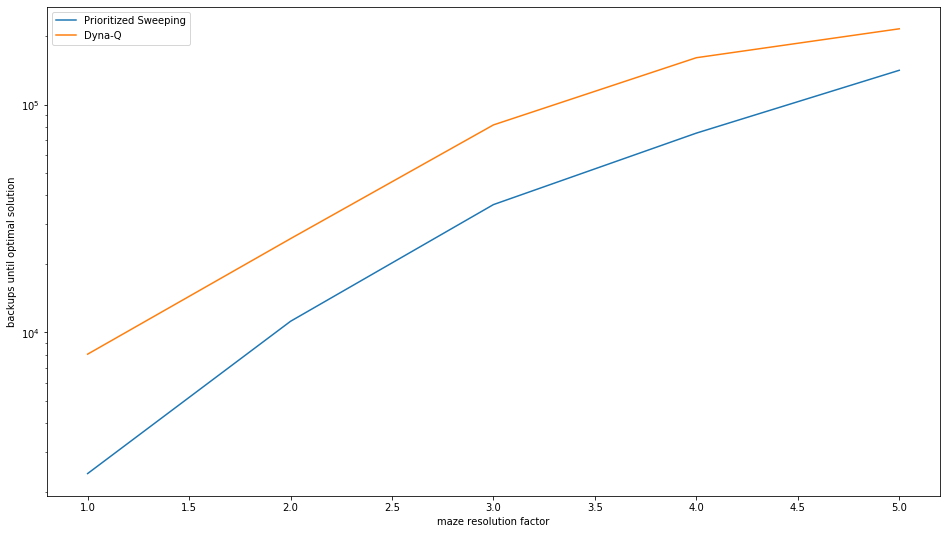

In [37]:
plt.figure(figsize=(16, 9))
for i in range(0, len(method_names)):
    plt.plot(np.arange(1, num_of_mazes + 1), backups[i, :], label=method_names[i])
plt.xlabel('maze resolution factor')
plt.ylabel('backups until optimal solution')
plt.yscale('log')
plt.legend()
plt.show()